
# Linear and Polynomial Regression: Electricity Consumption Based on Weather Data

**Dataset:** `electricity_consumption_based_weather_dataset.csv`  
**Task:** Predict fuel economy using regression  
**Models:**  
- Linear Regression  
- Polynomial Regression (degree 2, 3, 4)  
**Regularization:** **Not used** (as requested)

## Library Imports

In [ ]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


## 0.1 Utility functions (Including 70/30 data split)

These are helper functions to reduce repeated code in the rest of the notebook.

---

### What each function does

- **`split_data(X, y)`**  
  Performs a **70% / 30% train-test split** using a fixed `random_state` so that results are reproducible.

- **`prepare_xy(df_in)`**  
  Removes rows with missing values and splits the dataset into:
  - **X** = input features (all columns except the target)  
  - **y** = target variable (here: `Performance Index`)

- **`compute_metrics(y_true, y_pred)`**  
  Computes three standard regression evaluation metrics:
  - **MSE (Mean Squared Error):** penalizes large errors more strongly  
  - **MAE (Mean Absolute Error):** average absolute prediction error  
  - **R² (Coefficient of Determination):** measures how well the model explains the variance in the data

- **`print_fitted_equation(...)`**  
  Prints the fitted regression model equation using the learned coefficients.  
  For polynomial regression, the number of terms can become very large, so the notebook prints only the **top terms** with the largest coefficient magnitude.

- **`plot_actual_vs_predicted_test(...)`**  
  Creates a scatter plot for the **test set** showing:
  - **Actual values** (blue circles)
  - **Predicted values** (red x’s)  
  This helps visually compare how close the predictions are to real values.

- **`run_models_and_evaluate(...)`**  
  This is the main driver function that runs everything for a given scenario:
  - Trains **Linear Regression** and **Polynomial Regression (degrees 2, 3, 4)**
  - Evaluates **train and test** performance using MSE, MAE, and R²
  - Prints fitted equation (top terms)
  - Generates test-set scatter plots
  - Returns a clean results table for easy comparison

---


In [ ]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "daily_consumption"

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]

    if ("date" in X.columns):
      X = X.drop(columns=["date"])

    return X, y

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)



## 2.1 Load the dataset and inspect basic information

In this section, we load the dataset into a pandas DataFrame and perform a **basic sanity check** before building any models.

### What this code does
- **Loads the CSV file** into a pandas DataFrame (`df`)
- Prints the **shape** of the dataset:
  - number of rows = number of samples (students)
  - number of columns = number of features (variables)
- Prints the **column names** to understand what information is available
- Displays the **first few rows** using `head()` to preview the data format and values
- Shows **summary statistics** using `describe()`:
  - for numeric columns: mean, standard deviation, min/max, quartiles, etc.
  - for non-numeric columns: count, unique values, most common value, etc.
- Checks for **missing values** in each column

In [ ]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "electricity_consumption_based_weather_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (1433, 6)

Columns:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Missing values per column:


,0
date,0
AWND,15
PRCP,0
TMAX,0
TMIN,0
daily_consumption,0



## 2.2 70/30 Data Split, 2.3 Model Training, and 2.4 Model Evaluation

### What the code does
- Trains and evaluates the following models using a **70% / 30% random train-test split**:
  - **Linear Regression**
  - **Polynomial Regression** (degree **2**, **3**, and **4**)
- Reports **Train and Test** metrics:
  - **MSE**, **MAE**, and **R²**
- Prints the fitted model equation (top coefficient terms)
- Plots **Actual vs Predicted** values for the **test set**


Scenario: Electricity Consumption Based on Weather Data
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


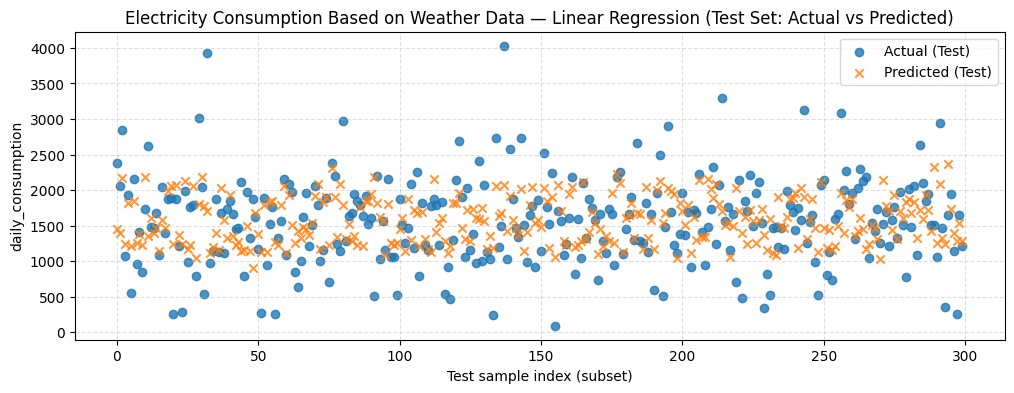


Scenario: Electricity Consumption Based on Weather Data
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


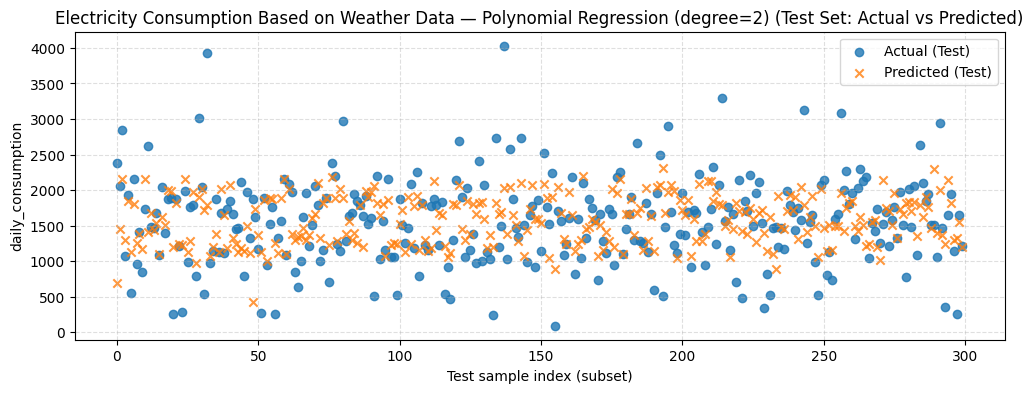


Scenario: Electricity Consumption Based on Weather Data
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


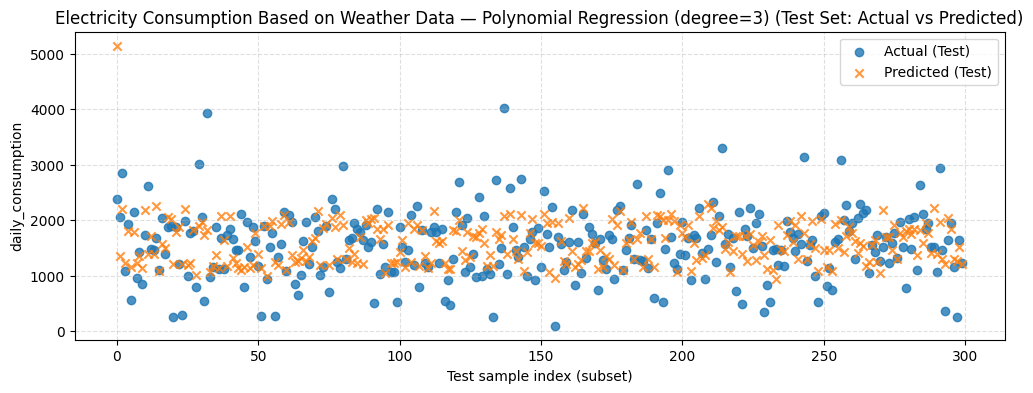


Scenario: Electricity Consumption Based on Weather Data
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


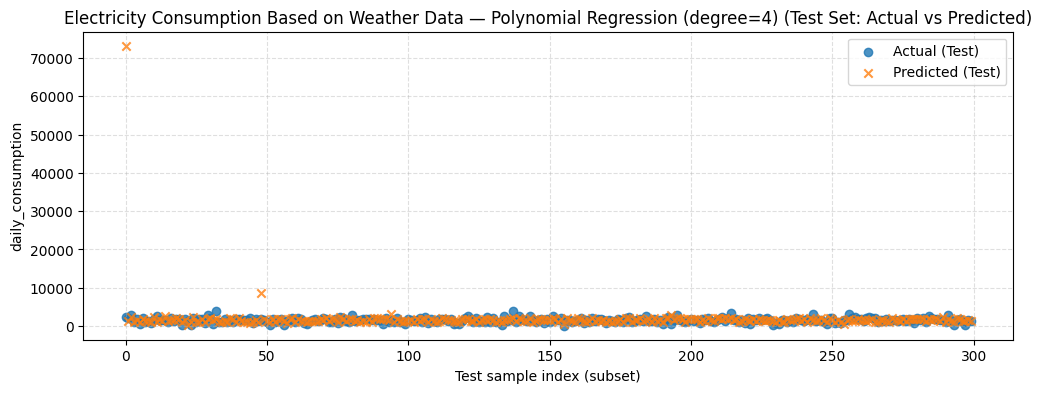

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Electricity Consumption Based on Weather Data,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,Electricity Consumption Based on Weather Data,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,Electricity Consumption Based on Weather Data,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,Electricity Consumption Based on Weather Data,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


In [ ]:

# ============================================================
# Part 2: Electricity Consumption Based on Weather Data
# ============================================================

results_part_1 = run_models_and_evaluate(
    df.copy(),
    scenario_name="Electricity Consumption Based on Weather Data",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_part_1)



## 2.5 Results Interpretation

### Guiding Questions
• Which model generalizes best (best test performance), and what does that tell you about the
relationship between weather and electricity usage?

  Although all of these models generalize pretty badly, the linear model performs the best out of the four with the lowest Test MSE and Test MAE and highest Test R^2 (2.481258e+05, 375.404537, and 0.299333 respectively).


---


• Do polynomial models improve the fit compared to linear regression? If yes, why might electricity
consumption have nonlinear dependence on weather?

  Polynomial models do not seem to improve the fit compared to linear regression on the testing set. Each subsequent higher polynomial degree decreases the ability to generalize the model.
  
  On the training side, however, there is an improvement when I increased degrees, but that is hardly the point if those models couldn't generalize better.


---


• If higher-degree models perform worse on the test set, explain this behavior using evidence from
metrics (e.g., train error decreases but test error increases).

  My numbers shows this trend where higher-degree models perform better on the train set but worse on the test set.
  
  For instance, when comparing linear to 3rd degree models, the Train MSE decreased (from 272403.396174 to 259249.534870) whereas the Test MSE increased (from 2.481258e+05 to 2.656237e+05).


---


• If none of the models achieve good test performance, provide at least two reasons supported by
your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior,
seasonal effects).

  Electricity consumption is a complex phenomenon where weather features could not be the only factors that affects it. We are definitely limited by some unmodeled drivers that are not included in the dataset. Moreover, there may be more noise in the existing data set that compromises the training, making the relationship between the (limited) inputs and output hard to learn, hence the models perform worse on new data.